In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adagrad

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from AttentionLayer.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [4]:
path = 'data/'
outputpath ='outputs/04_combination_samEval2018/'

In [5]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval()

In [6]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [7]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [8]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

train_pos =get_pos('output_trainTestData/SamEval_train_pos.csv')
test_pos = get_pos('output_trainTestData/SamEval_test_pos.csv')

In [9]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

train_senti_blob =get_sentiment('output_trainTestData/SamEval_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamEval_test_data_sentiment_blob.csv')

### Hyperparameter for all models

In [10]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


# Combine all

In [10]:
#Word Embeddings
wv_layer_all = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

input_embedding_all = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_all = wv_layer_all(input_embedding_all)
x_embedding_all = Dense(600, activation='relu')(embedded_sequences_all)
x_embedding_all = Dropout(0.2)(x_embedding_all)
x_embedding_all = Flatten()(x_embedding_all)

#Sentiment Features
input_sentiment_all = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_sentiment_all = Dense(600, activation='relu')(input_sentiment_all)
x_sentiment_all = Dropout(0.2)(x_sentiment_all)

#POS Features
input_pos_all = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_pos_all = Dense(600, activation='relu')(input_pos_all)
x_pos_all = Dropout(0.2)(x_pos_all)

#Concatination
concat_all = concatenate([x_embedding_all, x_sentiment_all, x_pos_all])
normal_all = BatchNormalization()(concat_all)
preds_all = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(normal_all)

model_all = Model(inputs=[input_embedding_all, input_sentiment_all, input_pos_all], outputs=preds_all)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


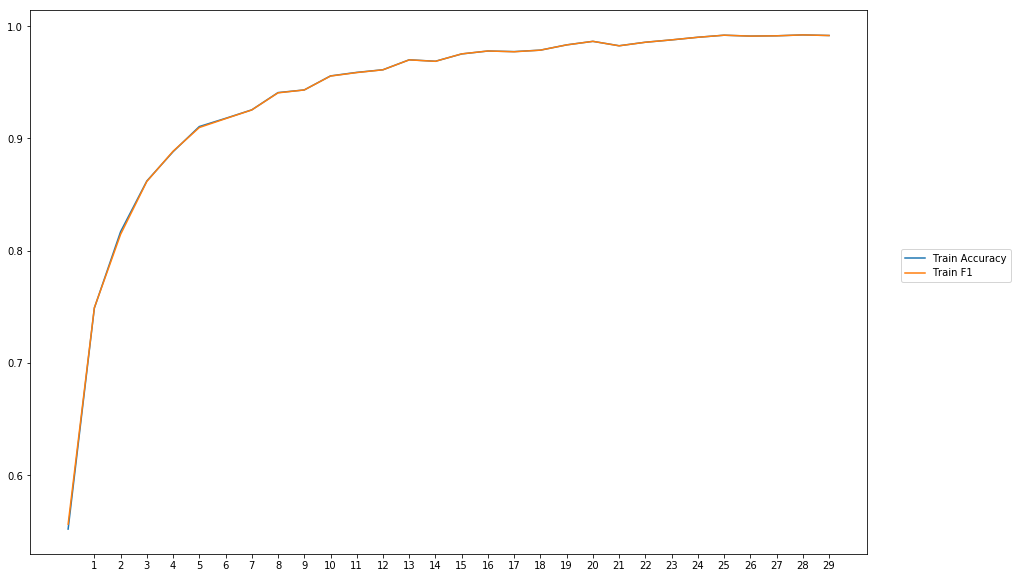


-----Test Scores----
Loss: 0.8116309472492763
Accuracy: 63.26530612244898
Precision: 53.083109905339654
Recall: 63.665594834834216
F1: 57.89473186625842


In [12]:
train_evaluate_three_inputs(model_all, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'Combineall')

## Combine batch normalization and dropout

In [13]:
#Word Embeddings
wv_layer_batchdrop = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

input_embedding_batchdrop = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_batchdrop = wv_layer_batchdrop(input_embedding_batchdrop)
x_embedding_batchdrop = Dense(600, activation='relu')(embedded_sequences_batchdrop)
x_embedding_batchdrop = Dropout(0.2)(x_embedding_batchdrop)
x_embedding_batchdrop = Flatten()(x_embedding_batchdrop)

#Sentiment Features
input_sentiment_batchdrop = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_sentiment_batchdrop = Dense(600, activation='relu')(input_sentiment_batchdrop)
x_sentiment_batchdrop = Dropout(0.2)(x_sentiment_batchdrop)

#POS Features
input_pos_batchdrop = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_pos_batchdrop = Dense(600, activation='relu')(input_pos_batchdrop)
x_pos_batchdrop = Dropout(0.2)(x_pos_batchdrop)

#Concatination
concat_batchdrop = concatenate([x_embedding_batchdrop, x_sentiment_batchdrop, x_pos_batchdrop])
normal_batchdrop = BatchNormalization()(concat_batchdrop)
preds_batchdrop = Dense(2, activation='softmax')(normal_batchdrop)

model_batchdrop = Model(inputs=[input_embedding_batchdrop, input_sentiment_batchdrop, input_pos_batchdrop], outputs=preds_batchdrop)

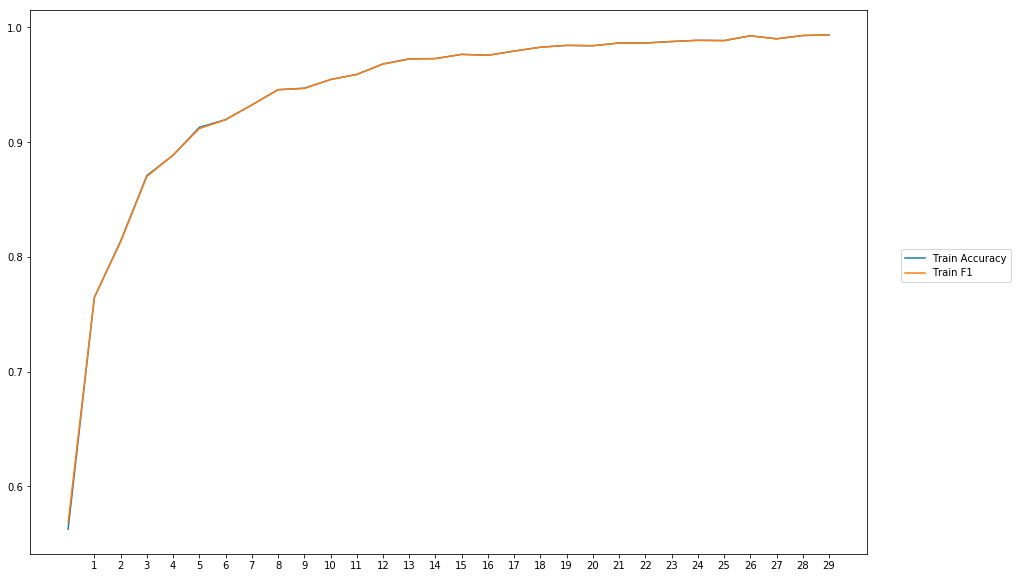


-----Test Scores----
Loss: 0.8175428424562726
Accuracy: 62.755102040816325
Precision: 52.405063277872145
Recall: 66.55948550914486
F1: 58.64022168306505


In [14]:
train_evaluate_three_inputs(model_batchdrop, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'CombineBatchDrop')

## Combine batch normalization and L2

In [15]:
#Word Embeddings
wv_layer_batchl2 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

input_embedding_batchl2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_batchl2 = wv_layer_batchl2(input_embedding_batchl2)
x_embedding_batchl2 = Dense(600, activation='relu')(embedded_sequences_batchl2)
x_embedding_batchl2 = Flatten()(x_embedding_batchl2)

#Sentiment Features
input_sentiment_batchl2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_sentiment_batchl2 = Dense(600, activation='relu')(input_sentiment_batchl2)

#POS Features
input_pos_batchl2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_pos_batchl2 = Dense(600, activation='relu')(input_pos_batchl2)

#Concatination
concat_batchl2 = concatenate([x_embedding_batchl2, x_sentiment_batchl2, x_pos_batchl2])
normal_batchl2 = BatchNormalization()(concat_batchl2)
preds_batchl2 = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(normal_batchl2)

model_batchl2 = Model(inputs=[input_embedding_batchl2, input_sentiment_batchl2, input_pos_batchl2], outputs=preds_batchl2)

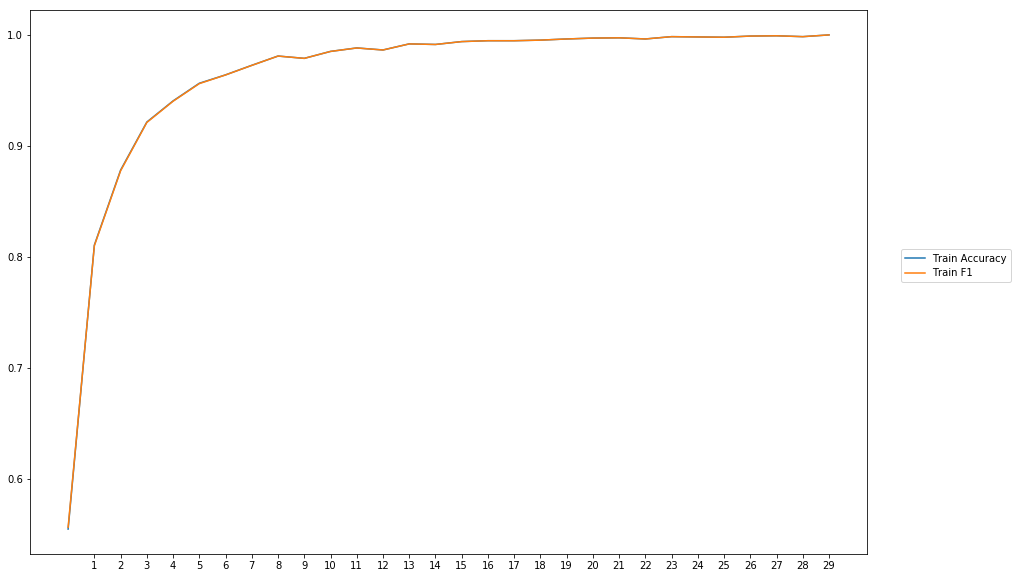


-----Test Scores----
Loss: 0.8260432323630975
Accuracy: 65.9438775510204
Precision: 55.69948185085506
Recall: 69.13183277519877
F1: 61.692964911066284


In [16]:
train_evaluate_three_inputs(model_batchl2, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'CombineBatchL2')

## Combine dropout and L2

In [11]:
#Word Embeddings
wv_layer_dropl2 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

input_embedding_dropl2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_dropl2 = wv_layer_dropl2(input_embedding_dropl2)
x_embedding_dropl2 = Dense(600, activation='relu')(embedded_sequences_dropl2)
x_embedding_dropl2 = Dropout(0.2)(x_embedding_dropl2)
x_embedding_dropl2 = Flatten()(x_embedding_dropl2)

#Sentiment Features
input_sentiment_dropl2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_sentiment_dropl2 = Dense(600, activation='relu')(input_sentiment_dropl2)
x_sentiment_dropl2 = Dropout(0.2)(x_sentiment_dropl2)

#POS Features
input_pos_dropl2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_pos_dropl2 = Dense(600, activation='relu')(input_pos_dropl2)
x_pos_dropl2 = Dropout(0.2)(x_pos_dropl2)

#Concatination
concat_dropl2 = concatenate([x_embedding_dropl2, x_sentiment_dropl2, x_pos_dropl2])
preds_dropl2 = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(concat_dropl2)

model_dropl2 = Model(inputs=[input_embedding_dropl2, input_sentiment_dropl2, input_pos_dropl2], outputs=preds_dropl2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


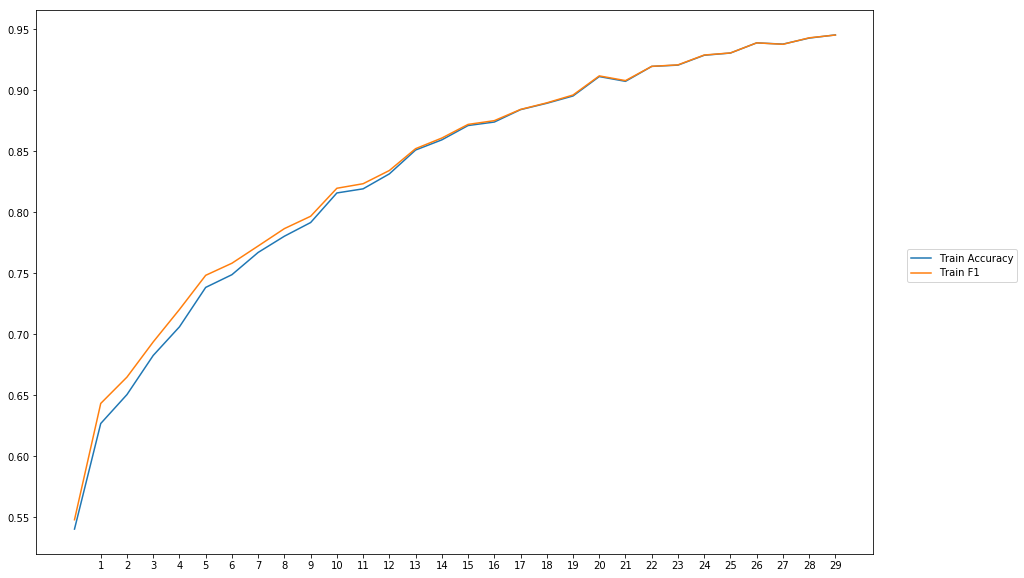


-----Test Scores----
Loss: 0.6130265423229763
Accuracy: 69.13265306122449
Precision: 59.102902359075756
Recall: 72.02572344950943
F1: 64.9275312616261


In [18]:
train_evaluate_three_inputs(model_dropl2, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'CombineDropL2')

Instructions for updating:
Use tf.cast instead.


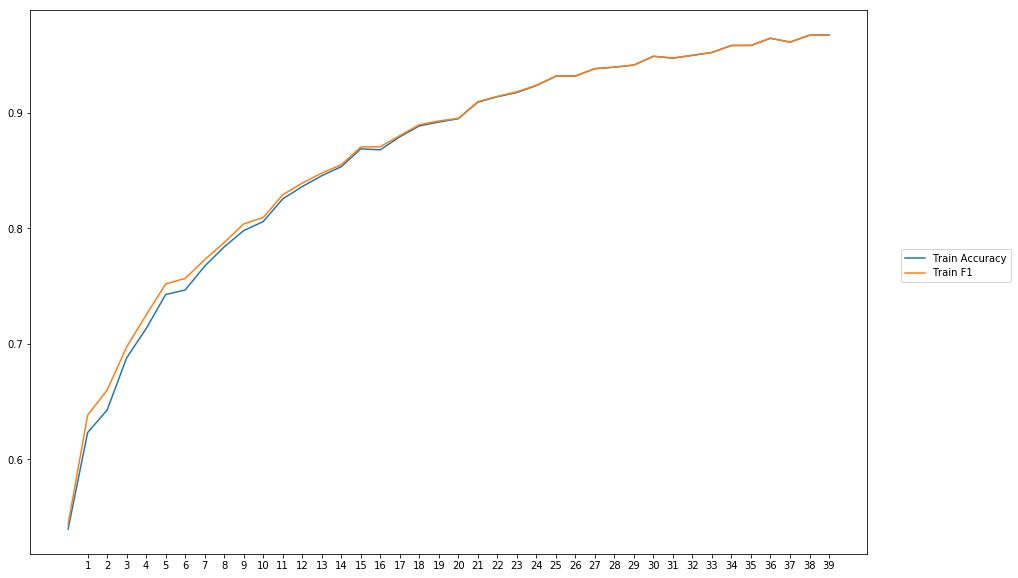


-----Test Scores----
Loss: 0.6362322909491402
Accuracy: 67.09183673469387
Precision: 56.95538056247891
Recall: 69.77491959171225
F1: 62.71675803881727


In [12]:
train_evaluate_three_inputs(model_dropl2, 40, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'CombineDropL2MoreEpochs')